# HELOC Credit Approval 
This notebook is ispired by the [AIX360](https://aix360.mybluemix.net/) [HELOC Credit Approval Tutorial](https://github.com/gianluigilopardo/AIX360/blob/master/examples/tutorials/HELOC.ipynb), which shows different explainability methods for a credit approval process.
Here [XGBoost](https://github.com/dmlc/xgboost) is used for classification, achieving better accuracy than most of the models used in that notebook. Then, feature importance methods are shown, to be compared with the *Data Scientist explanations* methods provided in the above notebook. The first ones come directly with XGBoost and the other is based on [SHAP](https://github.com/slundberg/shap).

The dataset is from the [FICO Explainable Machine Learning Challenge](https://community.fico.com/s/explainable-machine-learning-challenge) and it is about credit approval.

In [1]:
# math
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

# models
from sklearn.model_selection import train_test_split
from rulefit import RuleFit
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# visual
import matplotlib.pyplot as plt
from xgboost import plot_tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# utils
import random
SEED = 42
random.seed(SEED)
import warnings
warnings.filterwarnings('ignore')

# explainability 
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [2]:
path = 'heloc_dataset_v1.csv'
df = pd.read_csv(path) 
df.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,3,5,23,1,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,0,8,7,0,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,7,8,9,4,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,6,6,30,3,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,7,8,12,0,25,0,1,1,51,89,3,1,0,80


In [3]:
print("The dataset has " + str(df.shape[0])  + " instances and " + str(df.shape[1]-1) + " features.")

The dataset has 10459 instances and 23 features.


In [4]:
df.describe()

,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,MaxDelqEver,NumTotalTrades,NumTradesOpeninLast12M,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
count,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000,10459.000000
mean,67.425758,184.205373,8.543455,73.843293,19.428052,0.042738,-0.142843,86.661536,6.762406,4.928291,5.510183,20.856965,1.253083,32.166460,-0.325366,0.868152,0.812602,31.629888,39.158906,3.185008,0.976097,0.018071,62.079166
std,21.121621,109.683816,13.301745,38.782803,13.004327,2.513910,2.367397,25.999584,20.501250,3.756275,3.971182,14.580905,3.068684,20.128634,6.067556,3.179304,3.143698,30.060140,42.101601,4.413173,4.060995,3.358135,27.711565
min,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000,-9.000000
25%,63.000000,118.000000,3.000000,52.000000,12.000000,0.000000,0.000000,87.000000,-7.000000,4.000000,5.000000,12.000000,0.000000,20.000000,-7.000000,0.000000,0.000000,5.000000,-8.000000,2.000000,1.000000,0.000000,47.000000
50%,71.000000,178.000000,5.000000,74.000000,19.000000,0.000000,0.000000,96.000000,-7.000000,6.000000,6.000000,20.000000,1.000000,31.000000,0.000000,1.000000,1.000000,25.000000,47.000000,3.000000,2.000000,0.000000,67.000000
75%,79.000000,249.500000,11.000000,95.000000,27.000000,1.000000,0.000000,100.000000,14.000000,7.000000,8.000000,29.000000,3.000000,44.000000,1.000000,2.000000,2.000000,54.000000,79.000000,5.000000,3.000000,1.000000,82.000000
max,94.000000,803.000000,383.000000,383.000000,79.000000,19.000000,19.000000,100.000000,83.000000,9.000000,8.000000,104.000000,19.000000,100.000000,24.000000,66.000000,66.000000,232.000000,471.000000,32.000000,23.000000,18.000000,100.000000


In [5]:
X = df.drop(columns = 'RiskPerformance')
features = X.columns
y = df['RiskPerformance'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=SEED, stratify = y)

## XGBoost
The idea of boosting approach in machine learning is to create highly accurate predictions by combining many low-accurate rules. ”Wisdom of the crowds” is the basis concept behind Boosting, which takes a large amount of its foundations in the game theory field.

Boosting assumes the availability of a base or weak classifier, which it will see as a ”black-box” and that can be called repeatedly. This classification algorithm has to be at least better than taking random predictions (weak learning assumption). A boosting algorithm learns by repeatedly calling the base learning algorithm, but if this always works with the same data and in the same way, we can’t expect anything interesting. The key idea is to choose training sets for the base classifier in such a way to infer something new each time it is called.

[XGBoost](https://xgboost.ai/) stands for ”eXtreme Gradient Boosting”. It is a scalable, fast and well-performing tree boosting system, widely used in the data science community. It is designed for optimizing computational resources as it performs different optimization improvements which make it better than other boosting technique.

In [6]:
# Do cross validation to better choose (some) parameters
# or if you trust me set it False
CV = False

if CV:
    learning_rate =  [0.001, 0.01, 0.1]
    max_depth = np.arange(3,6)
    alpha = [0,2,10]
    colsample_bytree = [0,0.2,0.5]
    parameters = {'learning_rate': learning_rate, 'max_depth': max_depth,
                 'alpha': alpha, 'colsample_bytree':colsample_bytree}
    xgb_mod = xgb.XGBClassifier(objective='reg:logistic')
    xgb_mod = GridSearchCV(xgb_mod, parameters, scoring='f1', cv=5)
    xgb_mod.fit(X_train,y_train)
    print("The best parameters for XGB Classifier are %s with a score of %0.2f" % (xgb_mod.best_params_, xgb_mod.best_score_))
    
else: 
    xgb_mod = xgb.XGBClassifier(objective='reg:logistic', colsample_bytree=0.2, alpha=10,
                            learning_rate=0.1, max_depth=4, n_estimators=100)
    xgb_mod.fit(X_train,y_train)

In [7]:
xgb_pred = xgb_mod.predict(X_test)
print('Training accuracy:', accuracy_score(y_train, xgb_mod.predict(X_train)))
print('Test accuracy:', accuracy_score(y_test, xgb_pred))

Training accuracy: 0.746209534216637
Test accuracy: 0.7297641810070108


By looking at *Test accuracy* we se that XGBoost classifier outperformes Boolean Rule and Logistic Rule Regression models in the HELOC example.

In [8]:
if CV: xgb_mod = xgb_mod.best_estimator_

### Feature importance

What is more, it also provides different scoring systems to undestand features importance: 
* **Gain**: the average gain across all splits the feature is used in;
* **Total gain**: the total gain across all splits the feature is used in;
* **Coverage**: the average coverage across all splits the feature is used in;
* **Total coverage**: the total coverage across all splits the feature is used in;
* **Weight**: the number of times a feature is used to split the data across all trees.

In [9]:
def features_importance(xgb_mod, scoring_type):
    features_scoring = xgb_mod.get_booster().get_score(importance_type = scoring_type)
    features = list(features_scoring.keys())
    scores = list(features_scoring.values())

    data = pd.DataFrame(data=scores, index=features, columns=["score"]).sort_values(by = "score", ascending=True).tail(10)
    data.plot(kind='barh')
    plt.grid(color='k', linewidth=0.4)
    plt.show()

#### Gain
The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

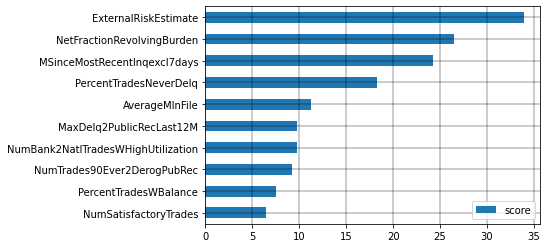

In [10]:
features_importance(xgb_mod, 'gain')

#### Total Gain

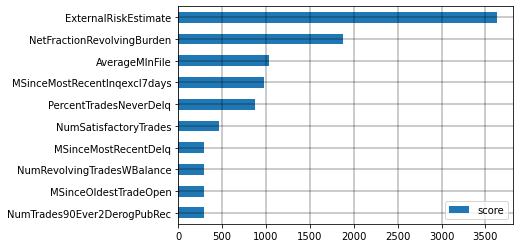

In [11]:
features_importance(xgb_mod, 'total_gain')

#### Coverage
The Coverage metric means the relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features’ cover metrics.

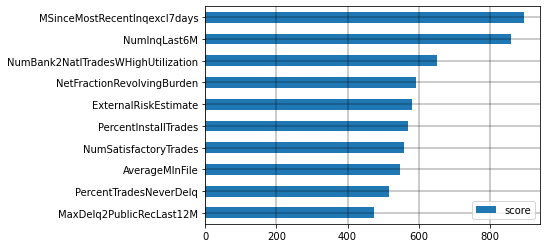

In [12]:
features_importance(xgb_mod, 'cover')

#### Total Coverage

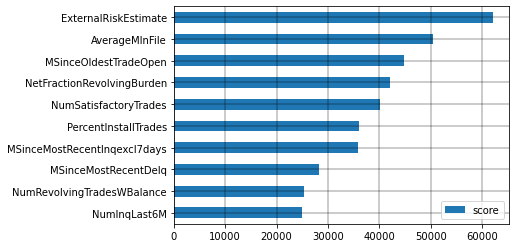

In [13]:
features_importance(xgb_mod, 'total_cover')

#### Weight
It is the number of times a feature is used to split the data across all trees.

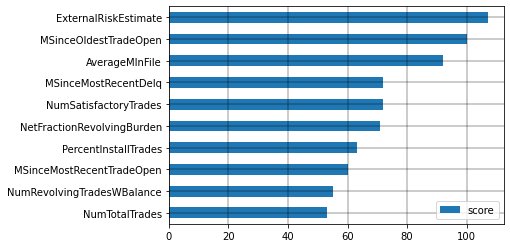

In [14]:
features_importance(xgb_mod, 'weight')

## SHAP
[SHAP (SHapley Additive exPlanations)](https://github.com/slundberg/shap) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

To get an overview of which features are most important for a model we can just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs), providing feature importance.

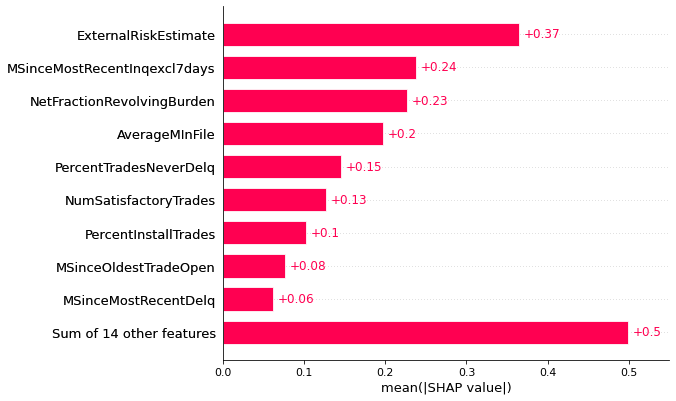

In [15]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_mod.get_booster())
shap_values = explainer(X)
shap.plots.bar(shap_values)

To go deeper, we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low).

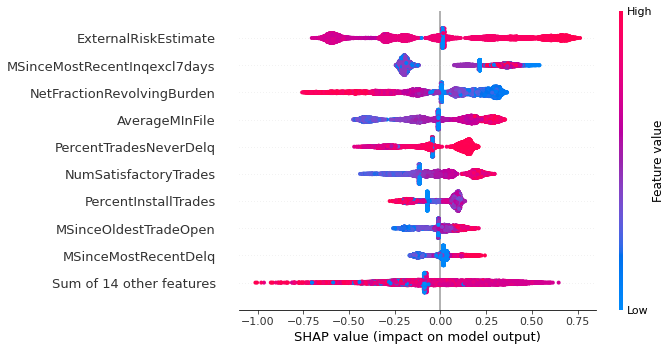

In [16]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

If we look for local explanation, SHAP can show features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

Let's look at the first prediction.

In [17]:
print('The first istance has been predicted as ' + xgb_pred[0])

The first istance has been predicted as Bad


Bad means no credit approval, Good means credit approval.

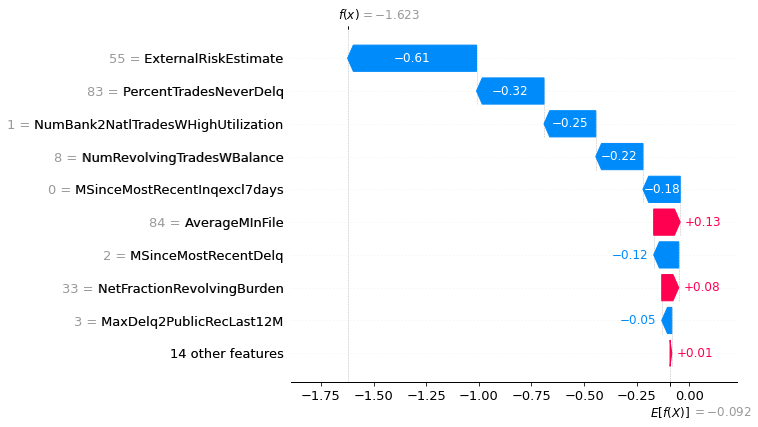

In [18]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [19]:
shap.plots.force(shap_values[0])